###  Computing spectral analysis on the data to estimate pairwise coherence

The methods to compute the spectral analysis can be imported as follows:

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import h5py
import scipy
import numpy                 as     np
import xarray                as     xr
import matplotlib.pyplot     as     plt
from   GDa.spectral_analysis      import filtering, time_frequency
from   GDa.spectral_analysis.util import smooth_spectra
from   GDa.session                import session

# Auxiliary function to smooth
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

#### Welch Coherence method from FRITES

In [2]:
import numpy as np
from scipy.signal import fftconvolve, coherence
import xarray as xr

from mne.time_frequency import tfr_array_morlet, tfr_array_multitaper

from frites.io import set_log_level, logger
from frites.utils import parallel_func
from frites.dataset import SubjectEphy
from frites.config import CONFIG

def _coherence_psd(x_s, x_t, win_sample, **kw_coh):
    """Compute the coherence for a single pair of channels."""
    coh = []
    for t_s, t_e in win_sample:
        _x_s, _x_t = x_s[..., t_s:t_e], x_t[..., t_s:t_e]
        freqs, _coh = coherence(_x_s, _x_t, **kw_coh)
        coh += [_coh]
    return freqs, np.stack(coh, axis=-1)


def conn_coherence_psd(data, roi=None, times=None, sfreq=None, pairs=None,
                       win_sample=None, n_jobs=-1, kw_coh={}, verbose=None):
    """Compute the single-trial pairwise coherence using Welch's method.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    roi : array_like | None
        ROI names of a single subject. If the input is an xarray, the
        name of the ROI dimension can be provided
    times : array_like | None
        Time vector array of shape (n_times,). If the input is an xarray, the
        name of the time dimension can be provided
    sfreq : float
        The sampling frequency
    pairs : array_like | None
        Pairs of contacts
    win_sample : array_like | None
        Array of shape (n_windows, 2) describing where each window start and
        finish. You can use the function :func:`frites.conn.define_windows`
        to define either manually either sliding windows. If None, the entire
        time window is used instead.
    n_jobs : int | 1
        Number of jobs to use for parallel computing (use -1 to use all
        jobs). The parallel loop is set at the pair level.
    kw_coh : dict | {}
        Additional arguments to send to the function
        :py:`scipy.signal.coherence`
    Returns
    -------
    coh : xarray.DataArray
        DataArray of shape (n_trials, n_pairs, n_freqs, n_windows)
    """
    set_log_level(verbose)

    # ___________________________________ I/O _________________________________
    if isinstance(data, xr.DataArray):
        trials, attrs = data[data.dims[0]].data, data.attrs
    else:
        trials, attrs = np.arange(data.shape[0]), {}

    # internal conversion
    data = SubjectEphy(data, y=trials, roi=roi, times=times, sfreq=sfreq)
    x, roi, times = data.data, data['roi'].data, data['times'].data
    trials, sfreq = data['y'].data, data.attrs['sfreq']
    n_trials, n_roi, n_times = data.shape

    # get the sorted non-directed pairs and build roi pairs names
    if (pairs is None):
        x_s, x_t = np.triu_indices(n_roi, k=1)
    else:
        assert isinstance(pairs, np.ndarray)
        assert (pairs.ndim == 2) and (pairs.shape[1] == 2)
        x_s, x_t = pairs[:, 0], pairs[:, 1]
    roi_s, roi_t = np.sort(np.c_[roi[x_s], roi[x_t]], axis=1).T
    roi_p = [f"{s}-{t}" for s, t in zip(roi_s, roi_t)]
    n_pairs = len(roi_p)

    # deal with the win_sample array
    if win_sample is None:
        win_sample = np.array([[0, len(times) - 1]])
    assert isinstance(win_sample, np.ndarray) and (win_sample.ndim == 2)
    assert win_sample.dtype in CONFIG['INT_DTYPE']
    n_win = win_sample.shape[0]

    # show info
    logger.info(f"Compute pairwise coherence (n_pairs={n_pairs})")

    # ________________________________ COHERENCY ______________________________
    kw_coh.update(dict(axis=-1, fs=sfreq))
    parallel, p_fun = parallel_func(
        _coherence_psd, n_jobs=n_jobs, verbose=verbose,
        total=n_pairs)
    coh = parallel(p_fun(x[:, s, :], x[:, t, :], win_sample,
                         **kw_coh) for s, t in zip(x_s, x_t))
    # unravel outputs
    (freqs, coh) = zip(*coh)
    freqs = freqs[0]
    coh = np.stack(coh, axis=1)

    # ________________________________ DATAARRAY ______________________________
    win_times = times[win_sample].mean(1)
    coh = xr.DataArray(coh, dims=('trials', 'roi', 'freqs', 'times'),
                       name='coh', coords=(trials, roi_p, freqs, win_times))

    return coh

Loading a session using the session class:

In [3]:
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])
ses.read_from_mat()

We can plot a random LFP signal:

In [4]:
lfp   = ses.data[0,10,:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
tarr  = ses.time

Text(0, 0.5, 'mV')

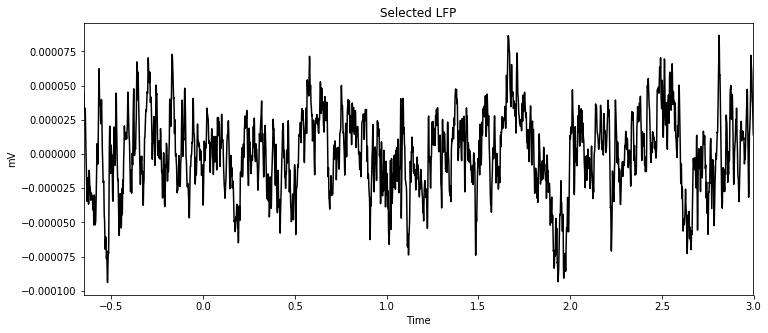

In [5]:
# Plotting the signal
plt.figure(figsize=(12,5))
plt.plot(tarr, lfp, 'k')
plt.xlim([tarr[0],tarr[-1]])
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the data with the function __bp_filter__ from __filtering__, let's filter it on the alpha band (8-15 Hz):

In [6]:
LFP_filtered = filtering.bp_filter(data = ses.data, fs = ses.data.attrs['fsample'], 
                                   f_low = 8, f_high = 12, n_jobs = -1)

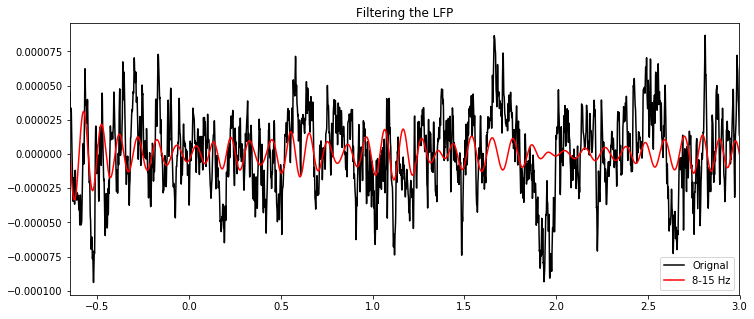

In [7]:
plt.figure(figsize=(12,5))
plt.plot(tarr, lfp, 'k')
plt.plot(tarr, LFP_filtered[0,10,:], 'r')
plt.xlim([tarr[0],tarr[-1]])
plt.title('Filtering the LFP')
plt.legend(['Orignal', '8-15 Hz'])

### Wavelet transform

We can compute the wavelets of the signal using the function __wavelet_transform__, which allows to use morlet or multitaper transforms.

In [235]:
# Bands for each monkey
bands = {
        'lucy':  [[0.1,6],[6,14],[14,26],[26,42],[42,80]],
        'ethyl': [[0.1,8],[8,21],[21,33],[33,80]]
        }
# Range of frequencies to be analyzed
freqs = np.linspace(0.1, 80, 80) 

In [166]:
def smoothed_power_spec(kernel, win_time, win_freq, delta=1, pad=False,pad_width=None):

    # Morlet
    W_ml = time_frequency.wavelet_transform(data = ses.data[0,2,:].values[None,None,:],  
           fs = ses.data.attrs['fsample'], freqs = freqs, 
           n_cycles = freqs/2, time_bandwidth = 8, 
           delta = delta, method = 'multitaper', n_jobs = 20)

    W_ml = np.squeeze(W_ml)
    S    = np.abs(W_ml)**2
    S    = smooth_spectra( np.abs(W_ml)**2, win_time, win_freq, 
           kernel=kernel, fft=True, axes=(0,1))
    return S

The auto spectra can be computed as tem elementwise product of $W$ and its conjugate:

In [167]:
S = smoothed_power_spec('square', 1, 1, delta=1)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.7s finished


In [168]:
S.shape

(100, 3650)

In [169]:
win

array([[   0,  300],
       [  10,  310],
       [  20,  320],
       [  30,  330],
       [  40,  340],
       [  50,  350],
       [  60,  360],
       [  70,  370],
       [  80,  380],
       [  90,  390],
       [ 100,  400],
       [ 110,  410],
       [ 120,  420],
       [ 130,  430],
       [ 140,  440],
       [ 150,  450],
       [ 160,  460],
       [ 170,  470],
       [ 180,  480],
       [ 190,  490],
       [ 200,  500],
       [ 210,  510],
       [ 220,  520],
       [ 230,  530],
       [ 240,  540],
       [ 250,  550],
       [ 260,  560],
       [ 270,  570],
       [ 280,  580],
       [ 290,  590],
       [ 300,  600],
       [ 310,  610],
       [ 320,  620],
       [ 330,  630],
       [ 340,  640],
       [ 350,  650],
       [ 360,  660],
       [ 370,  670],
       [ 380,  680],
       [ 390,  690],
       [ 400,  700],
       [ 410,  710],
       [ 420,  720],
       [ 430,  730],
       [ 440,  740],
       [ 450,  750],
       [ 460,  760],
       [ 470,

Next, we can visualize the result for __trial=0__, and __channel=10__:

In [170]:
S_avg = []
for w1,w2 in win:
    S_avg += [S[:,w1:w2]]

In [171]:
np.shape(win)

(335, 2)

In [172]:
out = np.mean(S_avg, axis=-1)

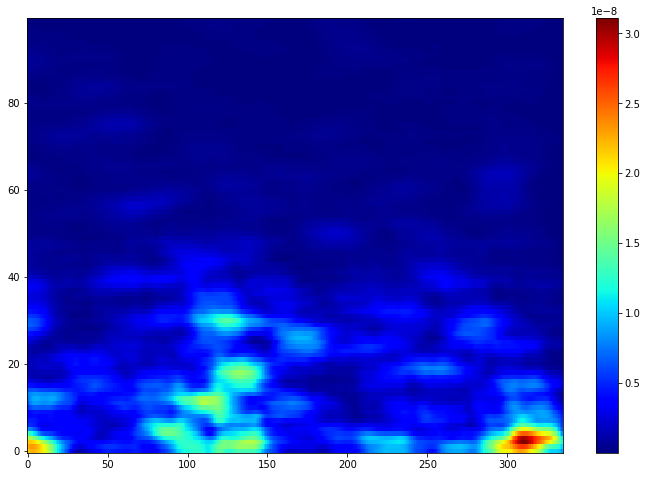

In [177]:
plt.figure(figsize=(12,8))
plt.imshow(out.T, aspect='auto', cmap='jet', origin='lower')
plt.colorbar()

In [174]:
Ss.shape

(100, 3650)

In [175]:
Ss = smoothed_power_spec('square', 300, 1, delta=1)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.6s finished


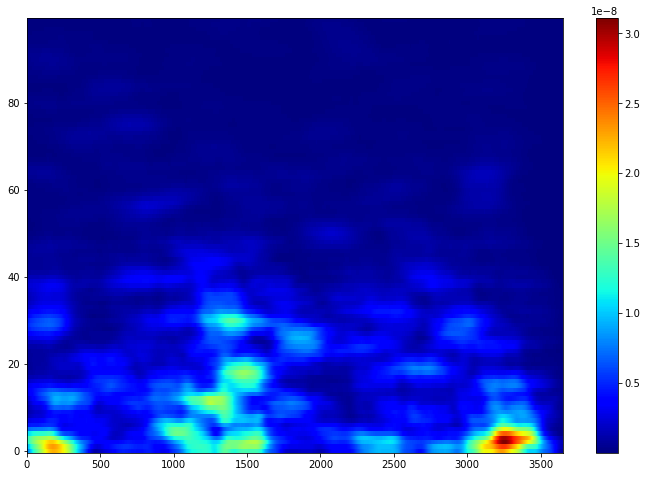

In [178]:
plt.figure(figsize=(12,8))
plt.imshow(Ss, aspect='auto', cmap='jet', origin='lower')
plt.colorbar()

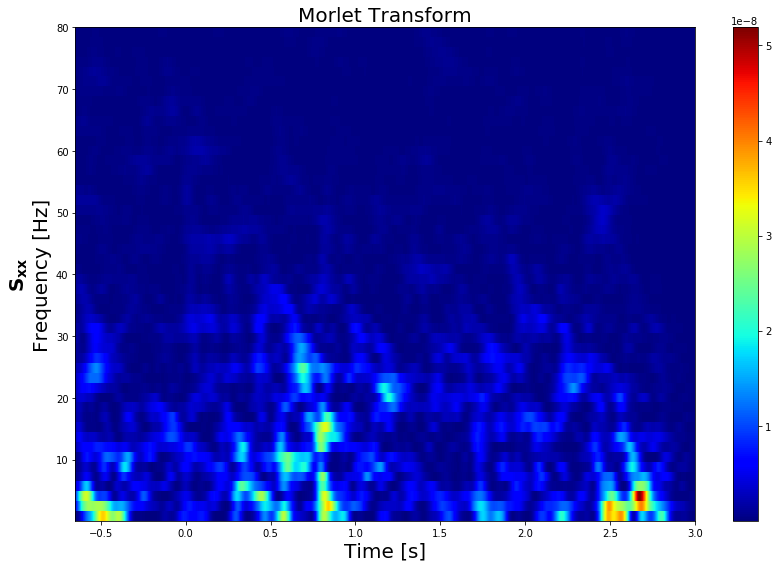

In [141]:
plt.figure(figsize=(12,8))
plt.imshow(S, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,freqs[0],freqs[-1]])
plt.colorbar()
plt.title('Morlet Transform', fontsize=20)
plt.ylabel(r"$\bf{S_{xx}}$" + "\n" + "Frequency [Hz]", fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.tight_layout()

#### Influence of smoothing window

In [11]:
win_time = [1, 10, 20, 50, 60]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out

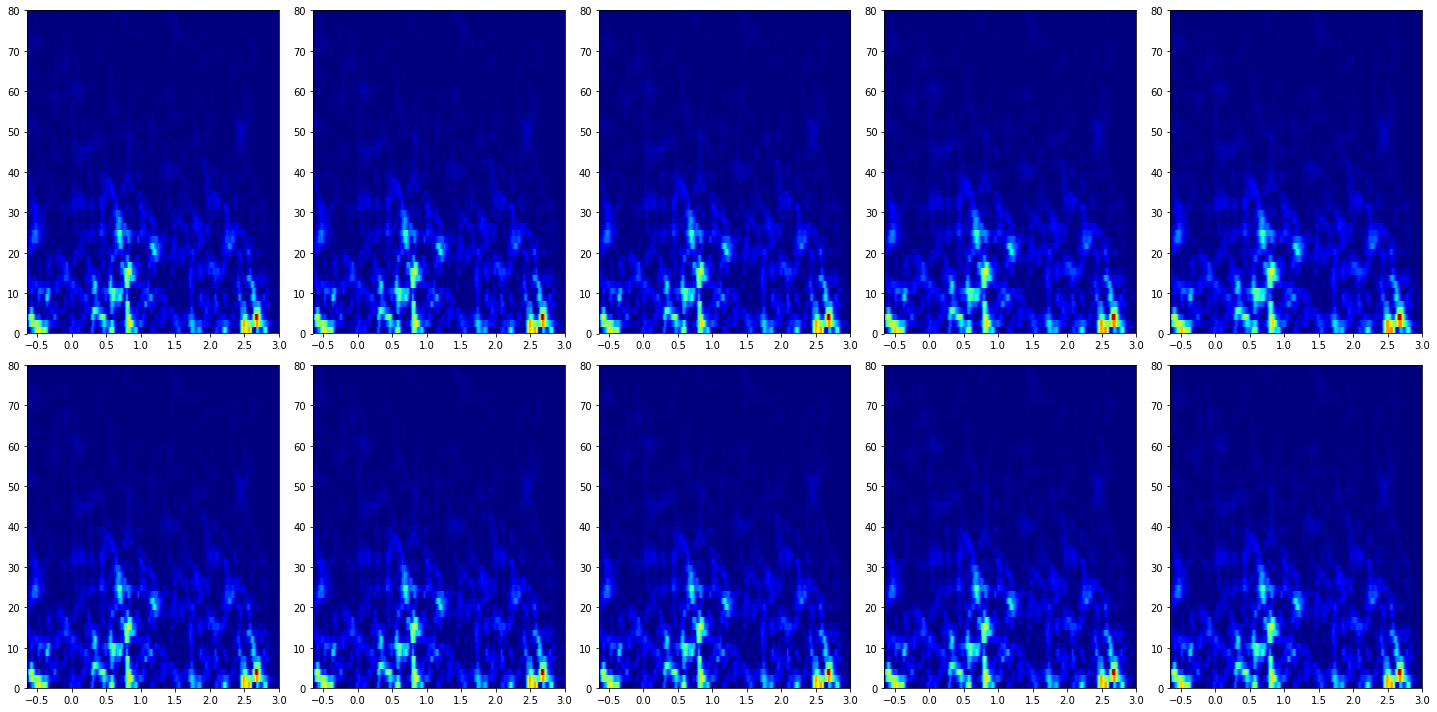

In [12]:
plt.figure(figsize=(20,10))
count = 1
for k in ['square', 'hann']:
    for wt in win_time:
        S = smoothed_power_spec(k, wt, 1)
        plt.subplot(2,len(win_time),count)
        plt.imshow(S, aspect='auto', cmap='jet', origin='lower', 
                   extent=[-0.65,3.00,freqs[0],freqs[-1]])
        count = count + 1
plt.tight_layout()

Finally we can compute the (single trial) time-frequency coherence between two signals by using the function __wavelet_coherence__, for each trial and pair a file will be saved in __dir_out__ with the coherence data.

An array with the pairs of channels (pairs = $[[0,1], [0,2], \dots, [n,n]]$) should be passed to the function (note that you don't necessarily have to provide every pair possible, you can also focus on a few pairs you are interested).

If $n_{\rm jobs}>1$, it will parallelize on pairs of channels, to test let's compute it passing only one trial of the data, and measure the execution time:

In [13]:
def smoothed_coh_spec(kernel, win_time, win_freq):
    _coh = time_frequency.wavelet_coherence(
        data = ses.data[0,:2,:].values[None,:,:], 
        pairs = np.array([[0,1]]), 
        fs = ses.data.attrs['fsample'], freqs = freqs, n_cycles = freqs/2, 
        time_bandwidth = None, delta = 15, method = 'multitaper', 
        kernel =kernel, win_time = win_time, baseline_correction=False, 
        win_freq = win_freq, dir_out = 'data', n_jobs = 20)
    
    return _coh

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parall

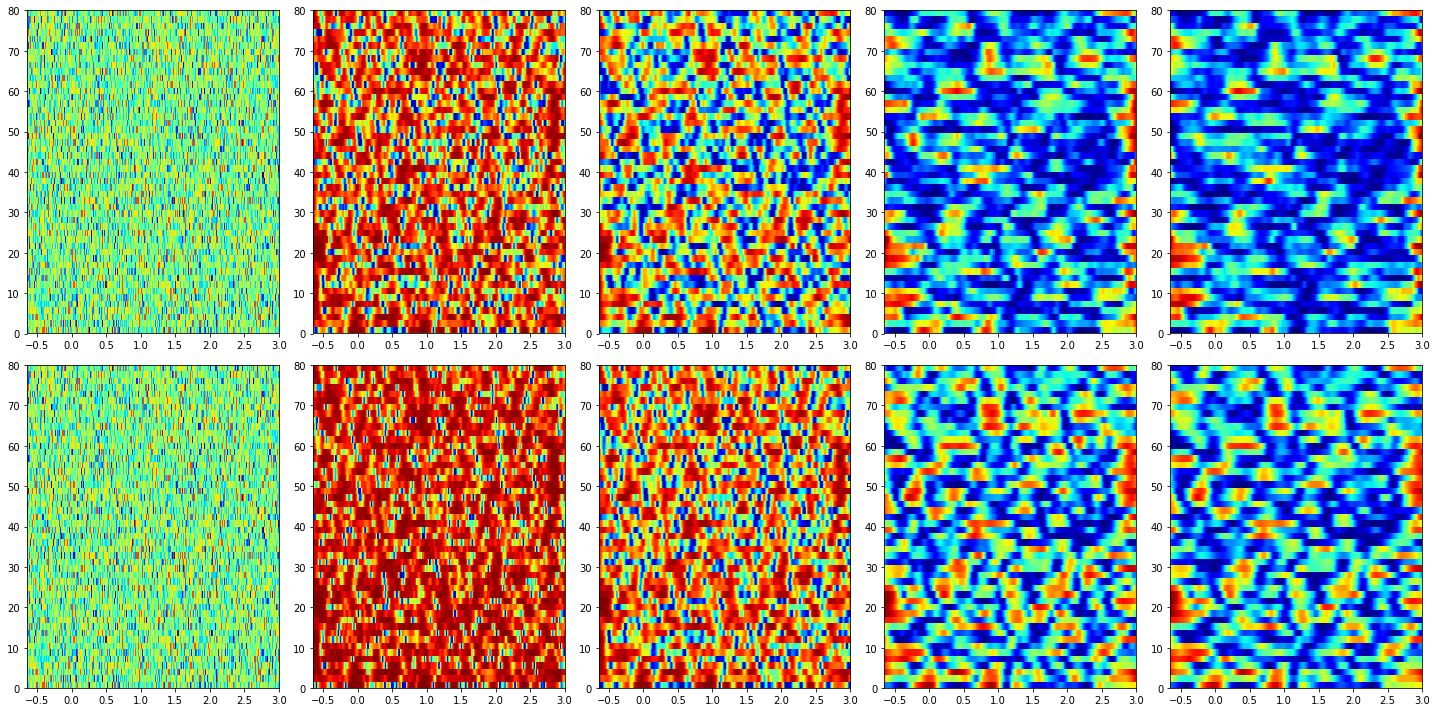

In [12]:
plt.figure(figsize=(20,10))
count = 1
for k in ['square', 'hann']:
    for wt in win_time:
        coh = smoothed_coh_spec(k, wt, 1)
        plt.subplot(2,len(win_time),count)
        plt.imshow(coh, aspect='auto', cmap='jet', 
                   origin='lower', extent=[-0.65,3.00,freqs[0],freqs[-1]])
        count = count + 1
plt.tight_layout()

In [236]:
start = time.time()

_coh = time_frequency.wavelet_coherence(
        data = ses.data.values, 
        pairs = np.array([[0,1]]), 
        fs = ses.data.attrs['fsample'], freqs = freqs, n_cycles = freqs/2, 
        time_bandwidth = 8.0, delta = 15, method = 'morlet', 
        kernel = 'square', win_time = 25, baseline_correction=False, 
        win_freq = 1, dir_out = 'data', n_jobs = -1
)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

For method equals "morlet" time_bandwidth is not used


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   48.2s remaining:  1.2min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   52.7s remaining:   33.4s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   57.0s remaining:   12.8s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:  1.1min finished


Elapsed time to load super-tensor: 105.23458576202393 sec.


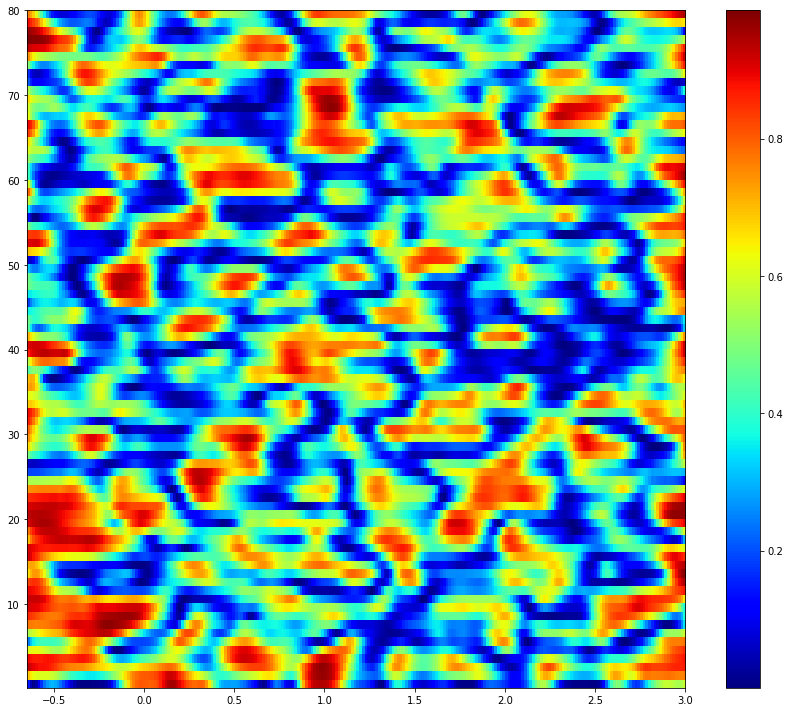

In [237]:
plt.figure(figsize=(12,10))
a = (_coh[0]-_coh[0].mean(axis=-1)[:,None])/_coh[0].std(axis=-1)[:,None]
plt.imshow(_coh[0], aspect='auto', cmap='jet', 
           origin='lower', extent=[-0.65,3.00,freqs[0],freqs[-1]])
plt.colorbar()
plt.tight_layout()

In [219]:
a=(_coh.mean(axis=0)-_coh.mean(axis=0).mean(axis=-1)[:,None])/_coh.mean(axis=0).std(axis=1)[:,None]

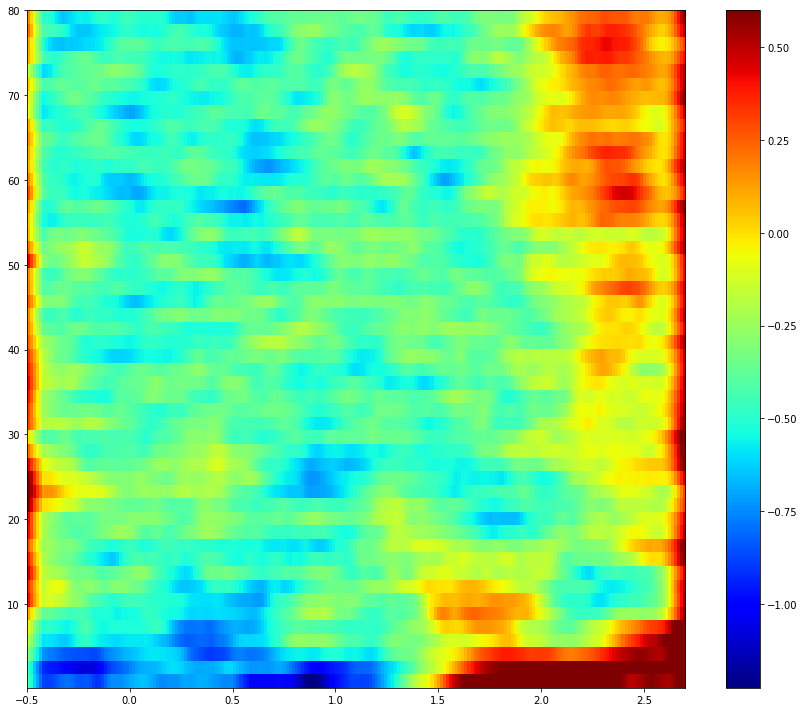

In [220]:
plt.figure(figsize=(12,10))
plt.imshow(a, aspect='auto', cmap='jet', 
           origin='lower', extent=[-0.65,3.00,freqs[0],freqs[-1]],vmax=.6)
plt.colorbar()
plt.xlim([-.5,2.7])
plt.tight_layout()

#### Using Welch

In [26]:
_coh.shape

(750, 50, 244)

In [203]:
from frites.conn import define_windows
win   = define_windows(tarr, slwin_len=1, slwin_step=.01)[0]

Defining temporal windows
    Definition of sliding windows (len=1, start=-0.65, stop=2.999000000000003, step=0.01)
    265 windows defined


In [204]:
win

array([[   0, 1000],
       [  10, 1010],
       [  20, 1020],
       [  30, 1030],
       [  40, 1040],
       [  50, 1050],
       [  60, 1060],
       [  70, 1070],
       [  80, 1080],
       [  90, 1090],
       [ 100, 1100],
       [ 110, 1110],
       [ 120, 1120],
       [ 130, 1130],
       [ 140, 1140],
       [ 150, 1150],
       [ 160, 1160],
       [ 170, 1170],
       [ 180, 1180],
       [ 190, 1190],
       [ 200, 1200],
       [ 210, 1210],
       [ 220, 1220],
       [ 230, 1230],
       [ 240, 1240],
       [ 250, 1250],
       [ 260, 1260],
       [ 270, 1270],
       [ 280, 1280],
       [ 290, 1290],
       [ 300, 1300],
       [ 310, 1310],
       [ 320, 1320],
       [ 330, 1330],
       [ 340, 1340],
       [ 350, 1350],
       [ 360, 1360],
       [ 370, 1370],
       [ 380, 1380],
       [ 390, 1390],
       [ 400, 1400],
       [ 410, 1410],
       [ 420, 1420],
       [ 430, 1430],
       [ 440, 1440],
       [ 450, 1450],
       [ 460, 1460],
       [ 470,

In [221]:
kw_coh=dict(nperseg=500, noverlap=400, nfft=1000)

start = time.time()

coh = conn_coherence_psd(ses.data.values, roi=None, times=None, sfreq=1000, 
                         pairs=np.array([[0,1]]), win_sample=win, n_jobs=-1, 
                         kw_coh=kw_coh, verbose=None)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1)



Elapsed time to load super-tensor: 131.07772755622864 sec.


In [224]:
coh = coh.squeeze(dim='roi')

In [225]:
coh

<xarray.DataArray 'coh' (trials: 750, freqs: 501, times: 265)>
array([[[3.75136683e-01, 3.98182093e-01, 4.67113751e-01, ...,
         1.09417294e-01, 1.29050597e-01, 1.15132248e-01],
        [6.57694284e-01, 6.85208767e-01, 7.13210098e-01, ...,
         5.01764823e-01, 5.33426251e-01, 5.38378826e-01],
        [6.02674225e-01, 6.10362750e-01, 6.11308644e-01, ...,
         3.95936343e-01, 4.13817610e-01, 4.25533558e-01],
        ...,
        [5.94664680e-03, 3.05262979e-02, 1.21232688e-01, ...,
         3.25350524e-01, 2.10148565e-01, 3.79306709e-02],
        [5.06642369e-01, 1.67833388e-01, 4.58315171e-01, ...,
         6.50589595e-01, 2.13989256e-01, 3.91780201e-01],
        [5.43955470e-03, 2.83739993e-02, 1.20803169e-01, ...,
         3.24554745e-01, 2.09488256e-01, 3.77313550e-02]],

       [[5.12667657e-04, 5.04016452e-05, 1.31600571e-02, ...,
         2.93864466e-01, 3.31323710e-01, 3.66378031e-01],
        [8.71322852e-02, 1.19868261e-01, 1.72528954e-01, ...,
         3.18624735e-01, 3.52608332e-01, 3.84966419e-01],
        [1.53255362e-01, 1.70094495e-01, 1.95363973e-01, ...,
         2.99301086e-01, 3.36006750e-01, 3.75503638e-01],
        ...,
        [2.05519954e-01, 7.81532884e-02, 6.38170783e-02, ...,
         3.13035131e-01, 6.34239708e-01, 1.01595758e-02],
        [4.29975430e-03, 5.93770130e-02, 2.90067944e-03, ...,
         6.70030388e-01, 2.99056347e-02, 1.36182368e-01],
        [2.04109789e-01, 8.27185750e-02, 6.37416580e-02, ...,
         3.13352020e-01, 6.36565127e-01, 1.00665177e-02]],

       [[3.29067703e-01, 2.48918417e-01, 1.79440372e-01, ...,
         1.31196660e-02, 5.77808725e-03, 7.81355627e-03],
        [7.42688658e-01, 6.99564876e-01, 6.77209158e-01, ...,
         3.36602304e-01, 3.16567404e-01, 2.96518455e-01],
        [7.09790831e-01, 6.78913860e-01, 6.59707324e-01, ...,
         2.76048919e-01, 2.48137515e-01, 2.28483449e-01],
        ...,
        [3.53454753e-01, 9.43917572e-02, 4.44116290e-02, ...,
         1.40007733e-02, 3.77508600e-02, 1.13346667e-01],
        [1.15172677e-01, 3.64957464e-02, 2.07702967e-01, ...,
         5.34874985e-03, 2.21086102e-03, 3.14438931e-02],
        [3.54509825e-01, 9.47191976e-02, 4.29832416e-02, ...,
         5.57019257e-03, 3.69930853e-02, 1.14719147e-01]],

       ...,

       [[1.69286365e-02, 5.56455875e-02, 1.27843975e-01, ...,
         8.43280654e-02, 8.38488041e-03, 3.42541540e-05],
        [1.48276738e-01, 1.90636770e-01, 2.28635656e-01, ...,
         6.32595820e-01, 6.06656678e-01, 5.50223515e-01],
        [1.59155951e-01, 1.81804980e-01, 1.95484793e-01, ...,
         5.52382773e-01, 5.33212160e-01, 5.16828826e-01],
        ...,
        [9.25988569e-04, 5.06872099e-02, 6.95357491e-02, ...,
         1.66303600e-01, 3.23092633e-01, 5.40972325e-03],
        [1.13760265e-01, 1.04843173e-02, 3.07118249e-03, ...,
         1.91171390e-01, 6.10314749e-01, 5.62390287e-03],
        [8.59444248e-04, 4.87400808e-02, 6.92970528e-02, ...,
         1.67458364e-01, 3.21360344e-01, 5.39490830e-03]],

       [[4.27556409e-01, 3.16499784e-01, 3.24105079e-01, ...,
         4.25806958e-01, 4.60098880e-01, 4.48942010e-01],
        [5.12418054e-01, 4.68302369e-01, 4.68365777e-01, ...,
         8.61948389e-01, 8.67452545e-01, 8.69636367e-01],
        [3.99240000e-01, 3.74265792e-01, 3.58744495e-01, ...,
         8.48193047e-01, 8.57731539e-01, 8.73190495e-01],
        ...,
        [1.00818329e-01, 9.58731928e-02, 8.95845887e-02, ...,
         1.29607772e-01, 3.19972742e-01, 2.04743198e-02],
        [5.25959095e-01, 4.17695304e-01, 2.34040545e-01, ...,
         3.72735683e-01, 9.64022654e-02, 4.84359077e-01],
        [1.00452050e-01, 9.53457214e-02, 8.97465173e-02, ...,
         1.29881403e-01, 3.22017846e-01, 1.85734225e-02]],

       [[2.53613328e-01, 3.02795512e-01, 2.31087876e-01, ...,
         2.85901751e-01, 2.77861525e-01, 2.63016343e-01],
        [7.33950523e-01, 7.46010029e-01, 7.10762236e-01, ...,
         6.92356641e-01, 6.59889020e-01, 6.62603127e-01],
        [

In [226]:
a=( coh.mean(dim='trials')-coh.mean(dim='trials').mean(dim='times') )/coh.mean(dim='trials').std(dim='times')

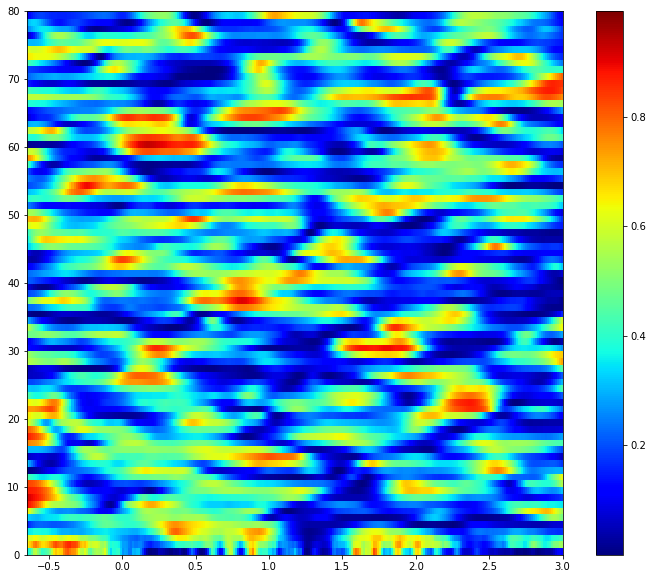

In [231]:
plt.figure(figsize=(12,10))
plt.imshow(coh[0], aspect='auto', cmap='jet', 
                   origin='lower', extent=[-0.65,3.00,coh.freqs[0],coh.freqs[-1]])
plt.ylim([0,80])
plt.colorbar()

In [234]:
coh.freqs.values

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

### Multitaper estimation of coherence

To estimate the coherence (or spectra) in given bands we can use the multitaper method. Supose that we have the center frequencies of each band $f_c = \{f_{0},\dots, f_{n}\}$, where $n$ is the number of bands, and the bandwidth of each band $\delta f = \{\delta f_{0},\dots,\delta f_{n}\}$.

If $t_b$ is the time bandwidth of the Multitaper transform, the number of cycles can be computed by:

$n_\rm{cycles} = t_b\frac{f_c}{\delta f}$

This can be used to compute the spctra (and the coherence) directly in each band of interest.

In [8]:
# Method to compute number of cycles for each band and bandwidth
def compute_n_cycles(f_c, d_f, time_bandwidth):
    return time_bandwidth * f_c / d_f

In [9]:
# Frequency centers
f_c = np.mean( bands['lucy'], axis = 1)
# Bandwidth
d_f = np.ceil( (np.array(bands['lucy'])[:,1]-np.array(bands['lucy'])[:,0])/2 )
# Time-bandwidth
time_bandwidth = 8.0
# Number of cycles
n_cycles = compute_n_cycles(f_c,d_f,time_bandwidth)

#### Power

In [39]:
freqs = np.arange(4, 100, 2)

W_ml = time_frequency.wavelet_transform(data = ses.data,  
       fs = ses.data.attrs['fsample'], freqs = f_c, n_cycles = n_cycles,
       time_bandwidth = time_bandwidth, delta = 15, method = 'multitaper', 
       n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   26.3s remaining:   38.1s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   27.3s remaining:   17.3s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   27.8s remaining:    6.3s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   36.0s finished


In [40]:
W_ml = xr.DataArray( W_ml, dims = ('trials', 'roi', 'bands', 'time') )

In [41]:
P = W_ml * np.conj(W_ml)

In [42]:
# Baseline correcting
P = (P - P.mean(dim='time')) / P.std(dim='time')

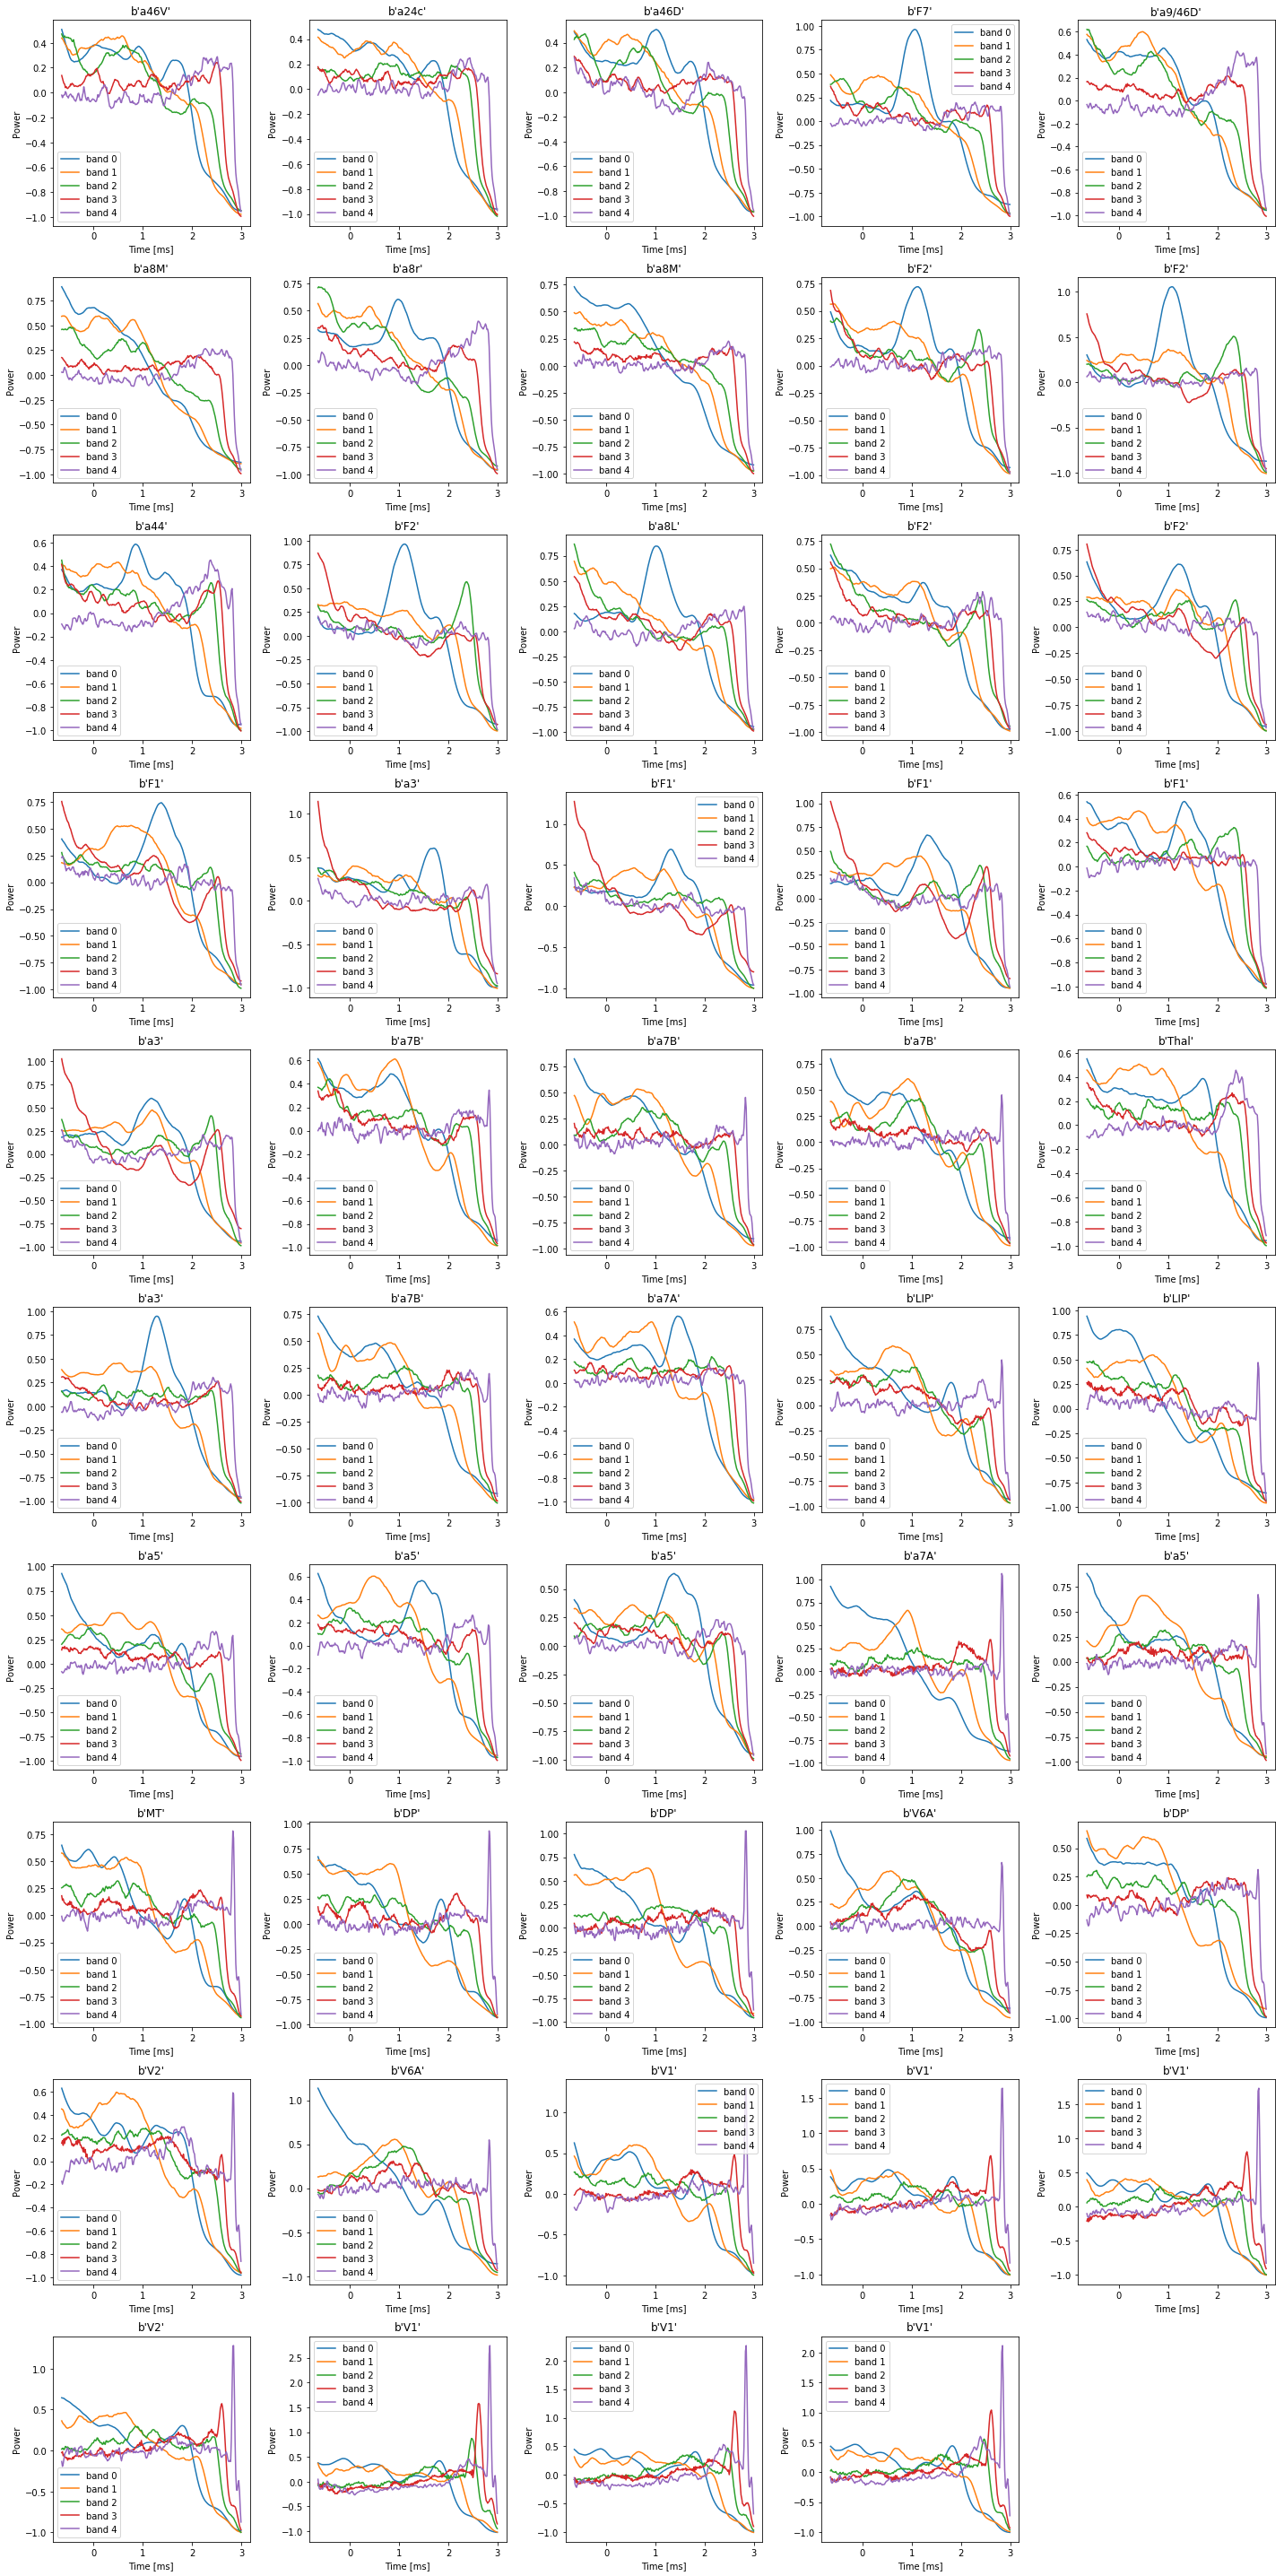

In [43]:
plt.figure(figsize=(20,40))
count = 1
for i in range(ses.data.attrs['nC']):
    plt.subplot(10,5,count)
    for j in range(len(bands['lucy'])):
        plt.plot(ses.data.time[::15], P.mean(dim = 'trials').real[i,j], label = 'band ' + str(j))
        plt.ylabel('Power')
        plt.xlabel('Time [ms]')
        plt.title(ses.data.attrs['areas'][i])
    count = count + 1
    plt.legend()
plt.tight_layout()
plt.savefig('power_mt.pdf', dpi = 600)

### Coherence

In [10]:
coh=time_frequency.wavelet_coherence(data = ses.data, pairs = ses.data.attrs['pairs'], 
                                 fs = ses.data.attrs['fsample'], freqs = f_c, n_cycles = n_cycles, 
                                 time_bandwidth = time_bandwidth, delta = 1, method = 'multitaper',kernel='square', 
                                 win_time = 500, win_freq = 10, dir_out = 'data', n_jobs = 20)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   32.6s remaining:    7.3s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   39.2s finished


KeyboardInterrupt: 

In [11]:
print(coh.shape)

(1176, 750, 5, 244)


In [48]:
idx = ((ses.trial_info['trial_type']==1.0) & (ses.trial_info['behavioral_response']==1.0)).values

In [49]:
coh=coh[:,idx,:,:]

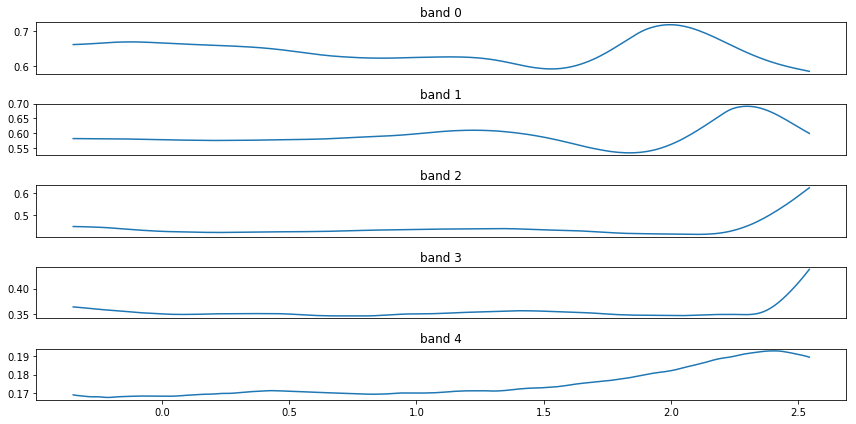

In [51]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(ses.time[::15][20:-30],coh.mean(axis=0).mean(axis=0)[i,20:-30])
    plt.title('band '+str(i))
    if i<4: plt.xticks([])
plt.tight_layout()

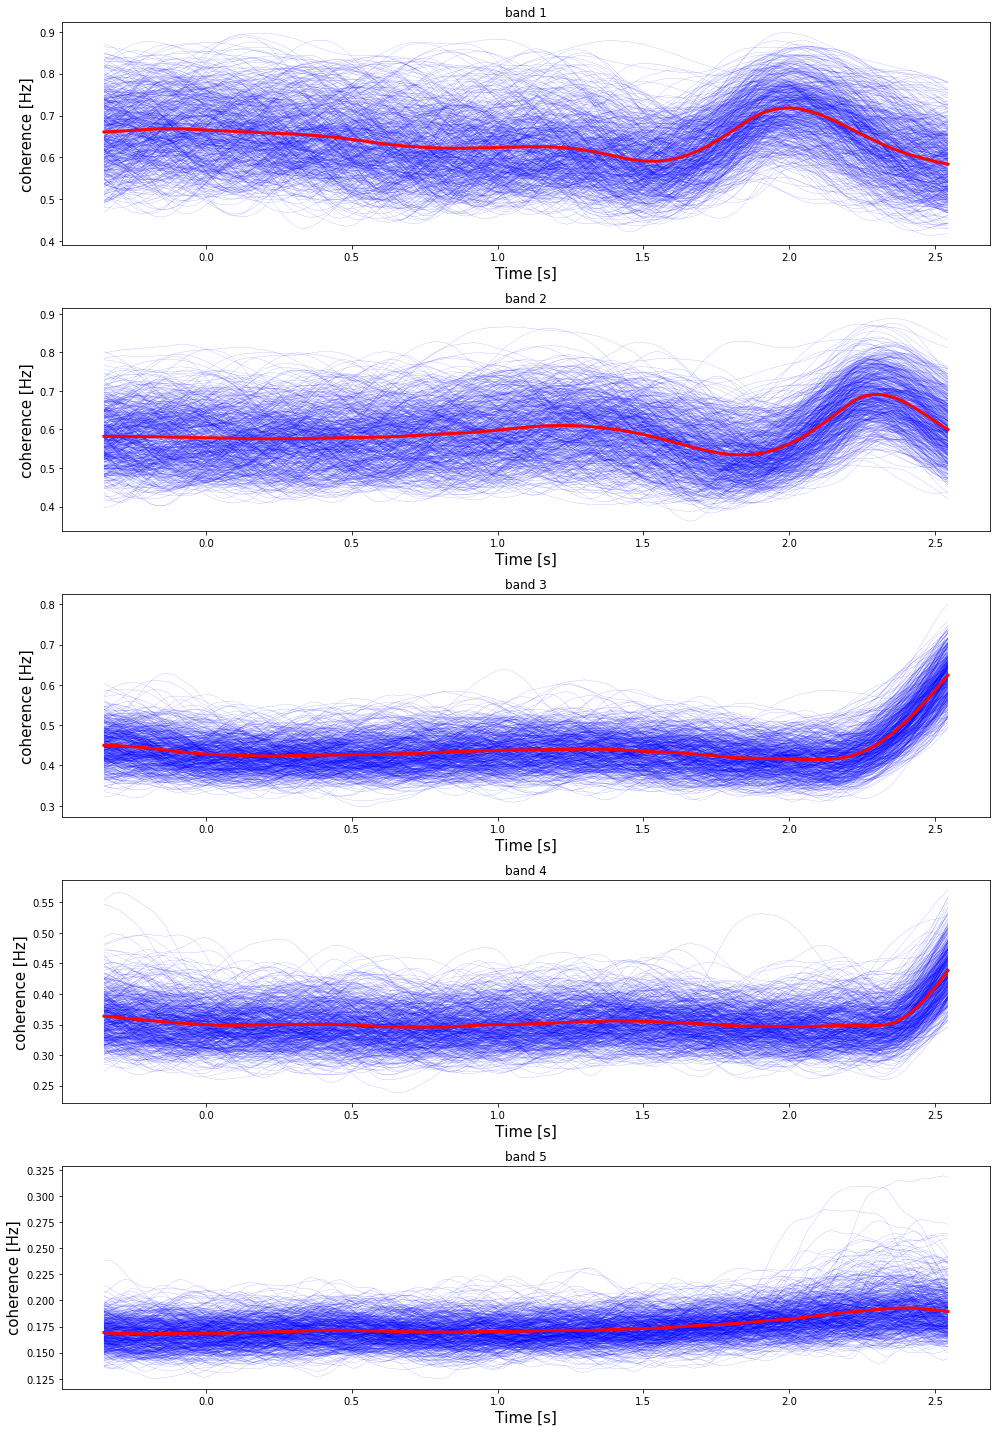

In [55]:
plt.figure(figsize=(14,20))
count = 1
for i in range(len(bands['lucy'])):
    plt.subplot(len(bands['lucy']),1,count)
    for j in range(coh.shape[1]):
        plt.plot(ses.data.time[::15][20:-30], coh[:,j,i,:].mean(axis=0)[20:-30], color='b', lw=.1)
        plt.title('band ' + str(i+1))
        plt.ylabel('coherence [Hz]', fontsize=15)
        plt.xlabel('Time [s]', fontsize=15)
    plt.plot(ses.data.time[::15][20:-30], coh[:,:,i,:].mean(axis=0).mean(axis=0)[20:-30], color='r', lw=3)
    count += 1
plt.tight_layout()
plt.savefig('coherence_mt.pdf', dpi = 600)

### Influence of temporal smoothing on the coherence

In [31]:
win_time = [10, 20, 30, 70, 100]

In [55]:
time_frequency.wavelet_coherence(data = ses.data, pairs = ses.data.attrs['pairs'], 
                                 fs = ses.data.attrs['fsample'], freqs = f_c, n_cycles = n_cycles, 
                                 time_bandwidth = time_bandwidth, delta = 15, method = 'multitaper', 
                                 win_time = 35, win_freq = 1, dir_out = 'data', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   28.7s remaining:   41.7s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   29.7s remaining:   18.8s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   30.6s remaining:    6.9s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   37.5s finished


In [56]:
coh = xr.DataArray(np.zeros((ses.data.attrs['nP'], ses.data.shape[0], len(f_c), len(ses.data.time[::15])) ) ,
                   dims=('links','trials','bands','time'),
                   coords={'time':ses.data.time[::15]})

In [57]:
p = 0
for ch1, ch2 in ses.data.attrs['pairs']:
    with h5py.File('data/ch1_'+str(ch1)+'_ch2_'+str(ch2)+'.h5', 'r') as hf:
        coh[p] = np.array(hf.get('coherence'))
    p+=1

In [58]:
coh_s = coh.sum(dim='links')

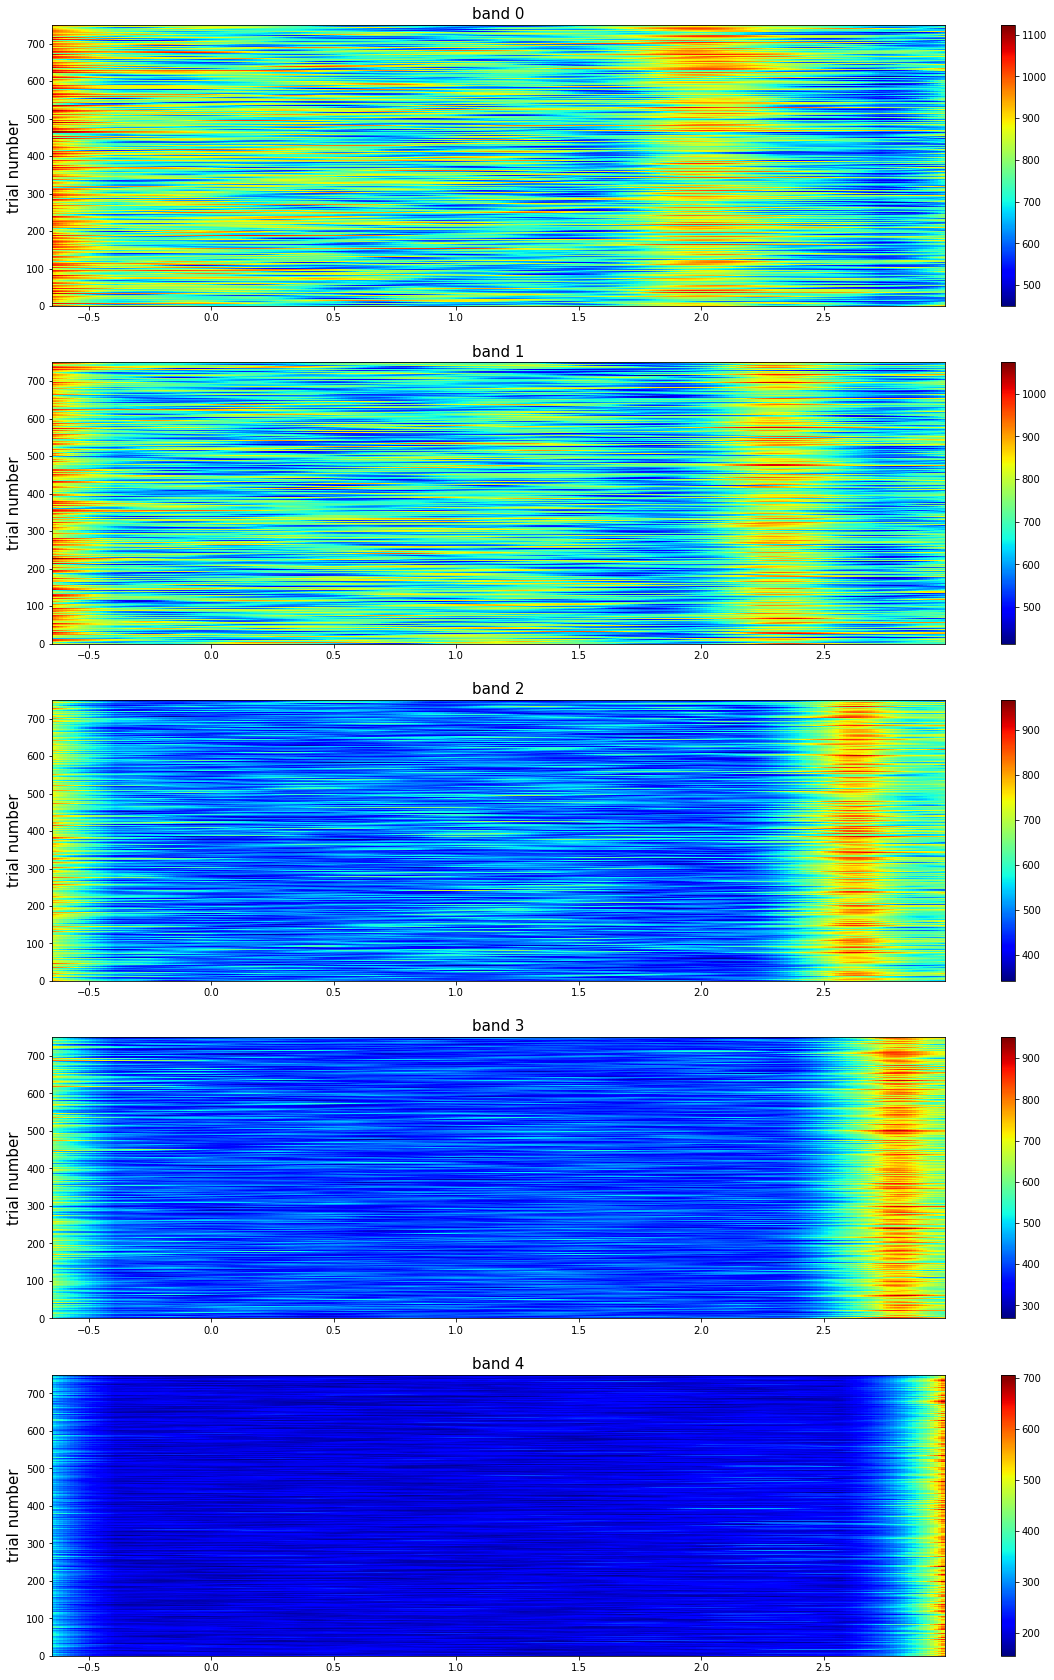

In [59]:
plt.figure(figsize=(20,30))
for i in range( len(f_c) ):
    plt.subplot(len(f_c),1,i+1)
    plt.imshow(coh_s.sel(bands=i),aspect='auto',cmap='jet',origin='lower', 
               extent=[coh_s.time[0], coh_s.time[-1], 0, len(coh_s.trials)])
    plt.colorbar()
    plt.ylabel('trial number', fontsize=15)
    if i == len(f_c): plt.xlabel('time [s]', fontsize=15)
    plt.title('band ' + str(i), fontsize=15)

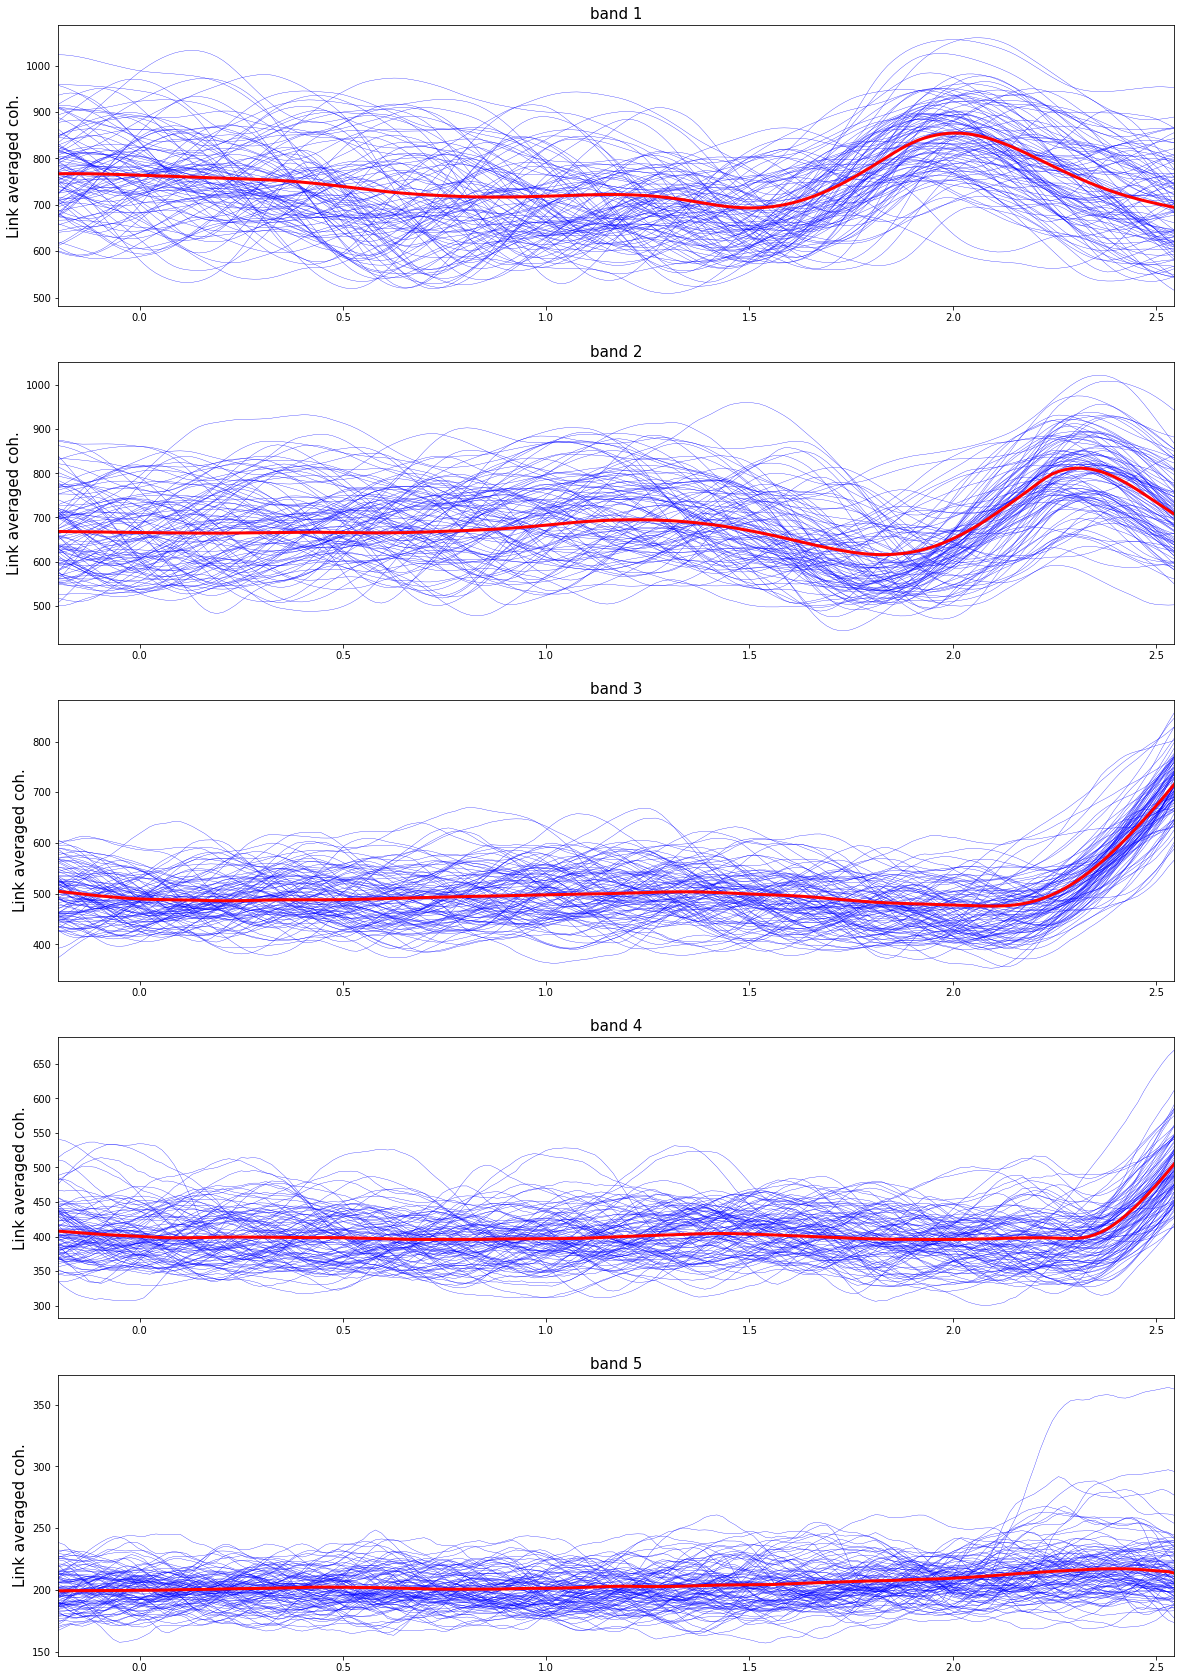

In [61]:
plt.figure(figsize=(20,30))
for i in range( len(f_c) ):
    plt.subplot(len(f_c),1,i+1)
    for j in range(100):
        plt.plot(coh_s.time[30:-30], coh_s.sel(bands=i)[j,30:-30], color='b', lw=.3)
    plt.plot(coh_s.time[30:-30], coh_s.sel(bands=i).mean(dim='trials')[30:-30], 'r', lw=3)
    plt.xlim(coh_s.time[30:-30][0],coh_s.time[30:-30][-1])
    plt.ylabel('Link averaged coh.', fontsize=15)
    if i == len(f_c): plt.xlabel('time [s]', fontsize=15)
    plt.title('band ' + str(i+1), fontsize=15)

In [8]:
"""Compute the PLV spectrum (C/GPU)."""
import numpy as np
import xarray as xr

from mne.time_frequency import morlet
from mne.utils import ProgressBar

from xfrites.utils import get_cupy, get_cusignal
from frites.io import set_log_level, logger
from frites.dataset import SubjectEphy


def conn_plv_spectrum(data, sfreq, freqs, n_cycles=7., roi=None, times=None,
                      poi=None, block_size=None, target='auto', verbose=None):
    """Compute the PLV spectrum.
    This function perform the following steps :
        * Get the complex decomposition in a specific frequency band using
          Morlet's wavelets
        * Compute the PLV across time points
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    sfreq : float
        The sampling frequency
    freqs : array_like
        Array of frequencies
    n_cycles : array_like | 7.
        Number of cycles to use for each frequency. If a float or an integer is
        used, the same number of cycles is going to be used for all frequencies
    times : array_like | None
        Time vector array of shape (n_times,). If the input is an xarray, the
        name of the time dimension can be provided
    roi : array_like | None
        ROI names of a single subject. If the input is an xarray, the
        name of the ROI dimension can be provided
    poi : tuple | None
        Period of interest in time units. Once the complex decomposition is
        performed on the entire time series, you can select a smaller temporal
        period of interest (e.g (0, 1.5) to select the period between 0s and
        1.5s)
    block_size : int | None
        Number of blocks of trials to process at once. This parameter can be
        use in order to decrease memory load. If None, all trials are used. If
        for example block_size=2, the number of trials are subdivided into two
        groups and each group is process one after the other.
    target : {'cpu', 'gpu', 'auto'}
        Context selection. Use either :
            * 'cpu' : force computing using CPU ressources
            * 'gpu' : force computing using GPU ressources
            * 'auto' : compute with GPU if possible otherwise use CPU
    Notes
    -----
    In order to be used on GPU this function require the python librairies
    CuPy such as Cusignal
    """
    set_log_level(verbose)
    # get librairies
    _, cp = get_cupy(target=target)
    target, signal = get_cusignal(target=target)

    # ___________________________________ I/O _________________________________
    if isinstance(data, xr.DataArray):
        trials, attrs = data[data.dims[0]].data, data.attrs
    else:
        trials, attrs = np.arange(data.shape[0]), {}
    # internal conversion
    data = SubjectEphy(data, y=trials, roi=roi, times=times)
    x, roi, times = data.data, data['roi'].data, data['times'].data
    trials = data['y'].data
    n_trials, n_roi, n_times = data.shape
    # inputs checking
    assert isinstance(freqs, (np.ndarray, list, tuple))
    if isinstance(n_cycles, (int, float)):
        n_cycles = [n_cycles] * len(freqs)
    assert len(n_cycles) == len(freqs)
    freqs, n_cycles = np.array(freqs), np.array(n_cycles)
    n_freqs = len(freqs)
    # period of interest
    poi = (times[0], times[-1]) if poi is None else poi
    idx_poi = np.abs(times.reshape(-1, 1) - np.array(
        poi).reshape(1, -1)).argmin(0)
    # get the sorted non-directed pairs and build roi pairs names
    x_s, x_t = np.triu_indices(n_roi, k=1)
    roi_s, roi_t = np.sort(np.c_[roi[x_s], roi[x_t]], axis=1).T
    roi_p = [f"{s}-{t}" for s, t in zip(roi_s, roi_t)]
    n_pairs = len(roi_p)

    # build block size indices
    if not isinstance(block_size, int):
        indices = [np.arange(n_trials)]
    else:
        n_blocks = np.floor_divide(n_trials, block_size)
        indices = np.array_split(np.arange(n_trials), n_blocks)

    # show info
    logger.info(f"Compute pairwise PLV spectrum (n_pairs={n_pairs}, "
                f"n_freqs={n_freqs}, target={target}), poi={idx_poi}")
    n_loops = int(n_freqs * len(indices))
    pbar = ProgressBar(range(n_loops), mesg='PLV spectrum estimation')

    # ___________________________________ PLV _________________________________

    # compute all required wavelets
    wav = {}
    for n_f in range(n_freqs):
        _wav = morlet(sfreq, freqs[[n_f]], n_cycles=n_cycles[[n_f]])
        wav[n_f] = cp.asarray(_wav).reshape(1, 1, -1)

    # loop over blocks of trials
    plv = np.zeros((n_trials, n_pairs, n_freqs))
    for n_b in range(len(indices)):
        idx_b = indices[n_b]
        # move the block of data to the gpu
        x_b = cp.asarray(x[idx_b, :])
        # compute plv for each trial
        _plv = cp.zeros((x_b.shape[0], n_pairs, n_freqs))
        for n_f in range(n_freqs):
            # compute the complex decomposition
            dcomp = signal.fftconvolve(x_b, wav[n_f], mode='same', axes=2)
            # poi selection
            dcomp = dcomp[..., idx_poi[0]:idx_poi[-1] + 1]
            # now get the phase
            pha = cp.angle(dcomp)
            # compute plv across all possible pairs
            for n_p, (s, t) in enumerate(zip(x_s, x_t)):
                da_s = pha[:, s, :]
                da_t = pha[:, t, :]
                __plv = cp.abs(cp.exp(1j * (da_s - da_t)).sum(-1))
                _plv[:, n_p, n_f] = __plv
            pbar.update_with_increment_value(1)
        # read out of gpu
        plv[idx_b, ...] = cp.asnumpy(_plv / float(n_times))

    # _________________________________ XARRAY ________________________________
    plv = xr.DataArray(plv, dims=('trials', 'roi', 'freqs'),
                       coords=(trials, roi_p, freqs), name='plv_spectrum')
    # set attributes
    cfg = dict(n_cycles=n_cycles, sfreq=sfreq, poi=poi)
    plv.attrs = {**attrs, **cfg}

    return plv

In [9]:
plv = conn_plv_spectrum(ses.data.values, 1000, freqs, n_cycles=7., 
                  roi=None, times=None,
                  poi=None, target='cpu', block_size=5, verbose=True)

WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise PLV spectrum (n_pairs=1176, n_freqs=50, target=cpu), poi=[   0 3649]


KeyboardInterrupt: 

Compute pairwise PLV spectrum (n_pairs=10, n_freqs=100, target=cpu), poi=[  0 999]



<xarray.DataArray 'plv_spectrum' (trials: 10, roi: 10, freqs: 100)>
array([[[0.57683743, 0.56091954, 0.47196506, ..., 0.14152818,
         0.14620901, 0.14931084],
        [0.25474655, 0.56739894, 0.28179466, ..., 0.03013907,
         0.03129767, 0.03275103],
        [0.39400036, 0.34268953, 0.24874422, ..., 0.07999093,
         0.0758781 , 0.07132656],
        ...,
        [0.54944912, 0.29557171, 0.17860307, ..., 0.00571004,
         0.01308141, 0.02063753],
        [0.15803129, 0.28974458, 0.38643765, ..., 0.15654919,
         0.15656939, 0.15180703],
        [0.58435992, 0.27576358, 0.40140368, ..., 0.06280127,
         0.06348274, 0.06290303]],

       [[0.61324606, 0.29415251, 0.28740361, ..., 0.0326723 ,
         0.03639187, 0.0375037 ],
        [0.1958585 , 0.2027396 , 0.2970777 , ..., 0.0172238 ,
         0.01646875, 0.01586879],
        [0.28822976, 0.12452212, 0.38545956, ..., 0.05826621,
         0.05892062, 0.05962152],
        ...,
        [0.68297207, 0.23349561, 0.3355

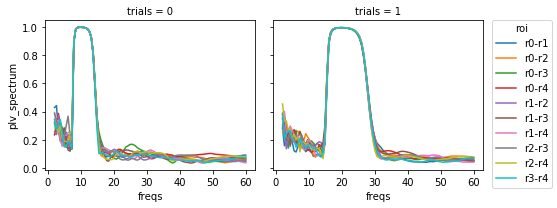

<xarray.DataArray 'plv_spectrum' (trials: 10, roi: 10, freqs: 100)>
array([[[0.57683743, 0.56091954, 0.47196506, ..., 0.14152818,
         0.14620901, 0.14931084],
        [0.25474655, 0.56739894, 0.28179466, ..., 0.03013907,
         0.03129767, 0.03275103],
        [0.39400036, 0.34268953, 0.24874422, ..., 0.07999093,
         0.0758781 , 0.07132656],
        ...,
        [0.54944912, 0.29557171, 0.17860307, ..., 0.00571004,
         0.01308141, 0.02063753],
        [0.15803129, 0.28974458, 0.38643765, ..., 0.15654919,
         0.15656939, 0.15180703],
        [0.58435992, 0.27576358, 0.40140368, ..., 0.06280127,
         0.06348274, 0.06290303]],

       [[0.61324606, 0.29415251, 0.28740361, ..., 0.0326723 ,
         0.03639187, 0.0375037 ],
        [0.1958585 , 0.2027396 , 0.2970777 , ..., 0.0172238 ,
         0.01646875, 0.01586879],
        [0.28822976, 0.12452212, 0.38545956, ..., 0.05826621,
         0.05892062, 0.05962152],
        ...,
        [0.68297207, 0.23349561, 0.33553

In [11]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt

    n_trials = 10
    n_roi = 5
    n_times = 1000
    sfreq = 128.
    trials = [0] * 5 + [1] * 5
    roi = [f"r{k}" for k in range(n_roi)]
    times = np.arange(n_times) / sfreq

    x = np.random.rand(n_trials, n_roi, n_times)
    x[0:5, ...] += np.sin(2 * np.pi * 10 * times).reshape(1, 1, -1)
    x[5::, ...] += np.sin(2 * np.pi * 20 * times).reshape(1, 1, -1)
    # x = np.random.normal(size=(n_trials, 1, n_times))
    # x = np.tile(x, (1, n_roi, 1))
    x = xr.DataArray(x, dims=('trials', 'roi', 'times'),
                     coords=(trials, roi, times))
    freqs = np.linspace(2, 60, 100)

    plv = conn_plv_spectrum(x, sfreq, freqs, roi='roi', times='times',
                            block_size=3, target='cpu')
    print(plv)
    plv.groupby('trials').mean('trials').plot.line(x='freqs', hue='roi',
                                                   col='trials')
    plt.show()
    print(plv)

In [131]:
from mne.time_frequency.tfr import _make_dpss

In [132]:
Ws = _make_dpss(1000, freqs, n_cycles=freqs/2, time_bandwidth=8.0, zero_mean=False)

In [133]:
np.shape(Ws)

(7, 50, 500)

Ws : list, shape (n_tapers, n_wavelets, n_times)

In [25]:
for W in Ws:
    print(len(W))

50
50
50
50
50
50
50


In [46]:
from scipy.signal import fftconvolve

In [114]:
t = np.arange(100)
x = np.random.randn(100)
x_c = fftconvolve(x, np.ones(5)/5, mode='valid', axes=0)
x_c2 = fftconvolve(x, np.ones(5)/5, mode='same', axes=0)

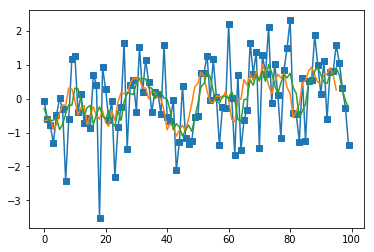

In [111]:
plt.plot(x, 's-')
plt.plot(x_c)
plt.plot(x_c2)

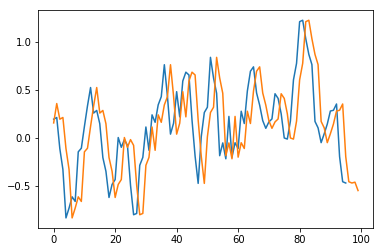

In [128]:
plt.plot(x_c)
plt.plot(x_c2)

In [118]:
np.mean(x[1:6])

0.21254923954171895

In [115]:
t_r=t[::5]

In [116]:
t_r.shape

(20,)

In [117]:
len(x)+5-1

104

In [9]:
idx = ses.trial_info[(ses.trial_info['trial_type']==1.0) \
                    & (ses.trial_info['behavioral_response']==1.0)].trial_index.values

data_filtered = ses.data.sel(trials=idx)

In [10]:
f, coh = scipy.signal.coherence(data_filtered[:,0,:], data_filtered[:,1,:], 
                       window='hann', nperseg=None, noverlap=None, 
                       nfft=None, detrend='constant', axis=- 1)

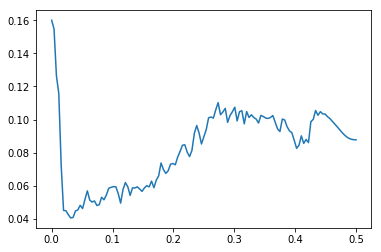

In [11]:
plt.plot(f, coh.mean(axis=0))

In [25]:
_coh = time_frequency.wavelet_coherence(
    data =  data_filtered.values, 
    pairs = np.array([[0,1]]), 
    fs = ses.data.attrs['fsample'], freqs = freqs, n_cycles = freqs/2, 
    time_bandwidth = 8.0, delta = 15, method = 'multitaper', 
    kernel = 'square', win_time = 300, baseline_correction=False, 
    win_freq = 1, dir_out = 'data', n_jobs = 10)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done  49 out of  49 | elapsed:  6.5min finished


KeyboardInterrupt: 

In [57]:
tarr

array([-0.65 , -0.649, -0.648, ...,  2.997,  2.998,  2.999])

In [14]:
0.3*1000/15

20.0

In [83]:
0.3 * 1000

300.0

In [125]:
tarr.shape

(3650,)